Proyek Analisis Data

Aldi Pascagama Nurrachman
pasca@student.uns.ac.id

In [3]:
#Menyiapkan library
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt
import seaborn as sns 
from babel.numbers import format_currency
sns.set(style='dark')

Menentukan Pertanyaan Bisnis

-Produk apa yang paling banyak diminati customer?

-wilayah mana yang paling banyak membeli produk perusahaan?

-apa metode pembayaran yang paling banyak dipakai?

In [4]:
#import seluruh dataset

dfc = pd.read_csv('data/customers_dataset.csv').set_index('customer_zip_code_prefix').sort_index()
dfg = pd.read_csv('data/geolocation_dataset.csv').drop_duplicates(subset='geolocation_zip_code_prefix',keep='first').set_index('geolocation_zip_code_prefix').sort_index()
dfoi = pd.read_csv('data/order_items_dataset.csv').set_index('order_id').sort_index()
dfop = pd.read_csv('data/order_payments_dataset.csv').set_index('order_id').sort_index()
dfor = pd.read_csv('data/order_reviews_dataset.csv').set_index('order_id').sort_index()
dfo = pd.read_csv('data/orders_dataset.csv').set_index('order_id').sort_index()
dfpc = pd.read_csv('data/product_category_name_translation.csv')
dfp = pd.read_csv('data/products_dataset.csv',usecols=['product_id','product_category_name'])
dfs = pd.read_csv('data/sellers_dataset.csv').set_index('seller_zip_code_prefix').sort_index()

In [5]:
df_customer = dfc.join(dfg).reset_index(names='customer_zip_code')                              
df_seller = dfs.join(dfg).reset_index(names='seller_zip_code')
df_order = dfo.join(dfoi).join(dfop).join(dfor).reset_index(names='order_id')
df_product = pd.merge(left=dfp,right=dfpc,how="left",left_on="product_category_name",right_on='product_category_name')


In [6]:
df_order_product = pd.merge(left=df_order,right=df_product,how='left',left_on='product_id',right_on='product_id')
df_order_customer = pd.merge(left=df_order_product,right=df_customer,how='left',left_on='customer_id',right_on='customer_id')
df = pd.merge(left=df_order_customer,right=df_seller,how='left',left_on='seller_id',right_on='seller_id')

Membuat Komponen Filter

In [7]:
def create_daily_orders_df(df):
    daily_orders_df = df.resample(rule='D', on='order_purchase_timestamp').agg({
        "order_id": "nunique",
        "price": "sum"
    })
    daily_orders_df = daily_orders_df.reset_index()
    daily_orders_df.rename(columns={
        "order_id": "order_count",
        "price": "revenue"
    }, inplace=True)
    
    return daily_orders_df

In [8]:
def create_sum_order_items_df(df):
    sum_order_items_df = df.groupby("product_category_name_english").order_item_id.sum().sort_values(ascending=False).reset_index()
    return sum_order_items_df

In [9]:
def create_bycity_df(df):
    bycity_df = df.groupby(by="geolocation_city_x").customer_id.nunique().reset_index().sort_values(by="customer_id", ascending=False)[0:10]
    bycity_df.rename(columns={
        "customer_id": "customer_count"
    }, inplace=True)
    
    return bycity_df

In [10]:
def create_bypayment_df(df):
    bypayment_df = df.groupby(by="payment_type").customer_id.nunique().reset_index()
    bypayment_df.rename(columns={
        "customer_id": "customer_count"
    }, inplace=True)
    
    return bypayment_df

In [11]:
datetime_columns = ["order_purchase_timestamp", "order_delivered_customer_date"]
df.sort_values(by="order_purchase_timestamp", inplace=True)
df.reset_index(inplace=True)

for column in datetime_columns:
    df[column] = pd.to_datetime(df[column])

In [12]:
min_date = df["order_purchase_timestamp"].min()
max_date = df["order_purchase_timestamp"].max()
 
with st.sidebar:
    # Menambahkan logo perusahaan
    st.image("https://github.com/dicodingacademy/assets/raw/main/logo.png")
    
    # Mengambil start_date & end_date dari date_input
    start_date, end_date = st.date_input(
        label='Rentang Waktu',min_value=min_date,
        max_value=max_date,
        value=[min_date, max_date]
    )

In [13]:
main_df = df[(df["order_purchase_timestamp"] >= str(start_date)) & 
                (df["order_purchase_timestamp"] <= str(end_date))]

In [14]:
daily_orders_df = create_daily_orders_df(main_df)
sum_order_items_df = create_sum_order_items_df(main_df)
bycity_df = create_bycity_df(main_df)
bypayment_df = create_bypayment_df(main_df)

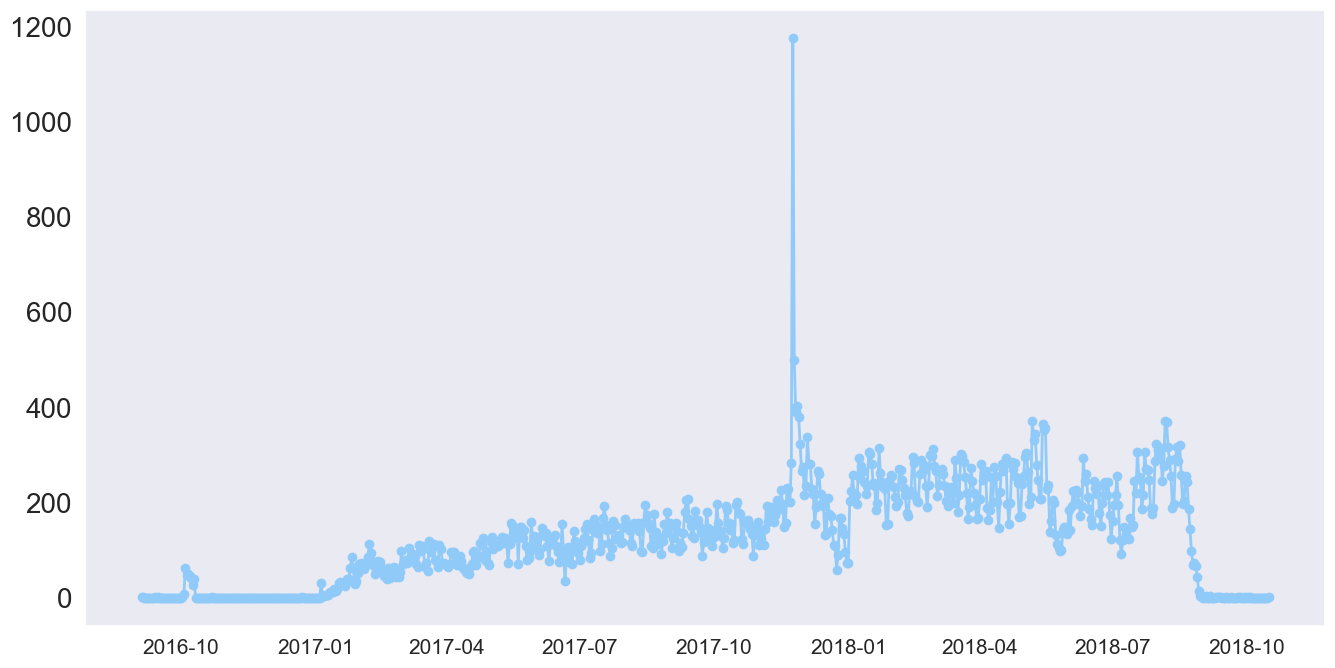

In [30]:
st.subheader('Daily Orders')
 
col1, col2 = st.columns(2)
 
with col1:
    total_orders = daily_orders_df.order_count.sum()
    st.metric("Total orders", value=total_orders)
 
with col2:
    total_revenue = format_currency(daily_orders_df.revenue.sum(), "AUD", locale='es_CO') 
    st.metric("Total Revenue", value=total_revenue)
 
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(
    daily_orders_df["order_purchase_timestamp"],
    daily_orders_df["order_count"],
    marker='o', 
    linewidth=2,
    color="#90CAF9"
)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=15)

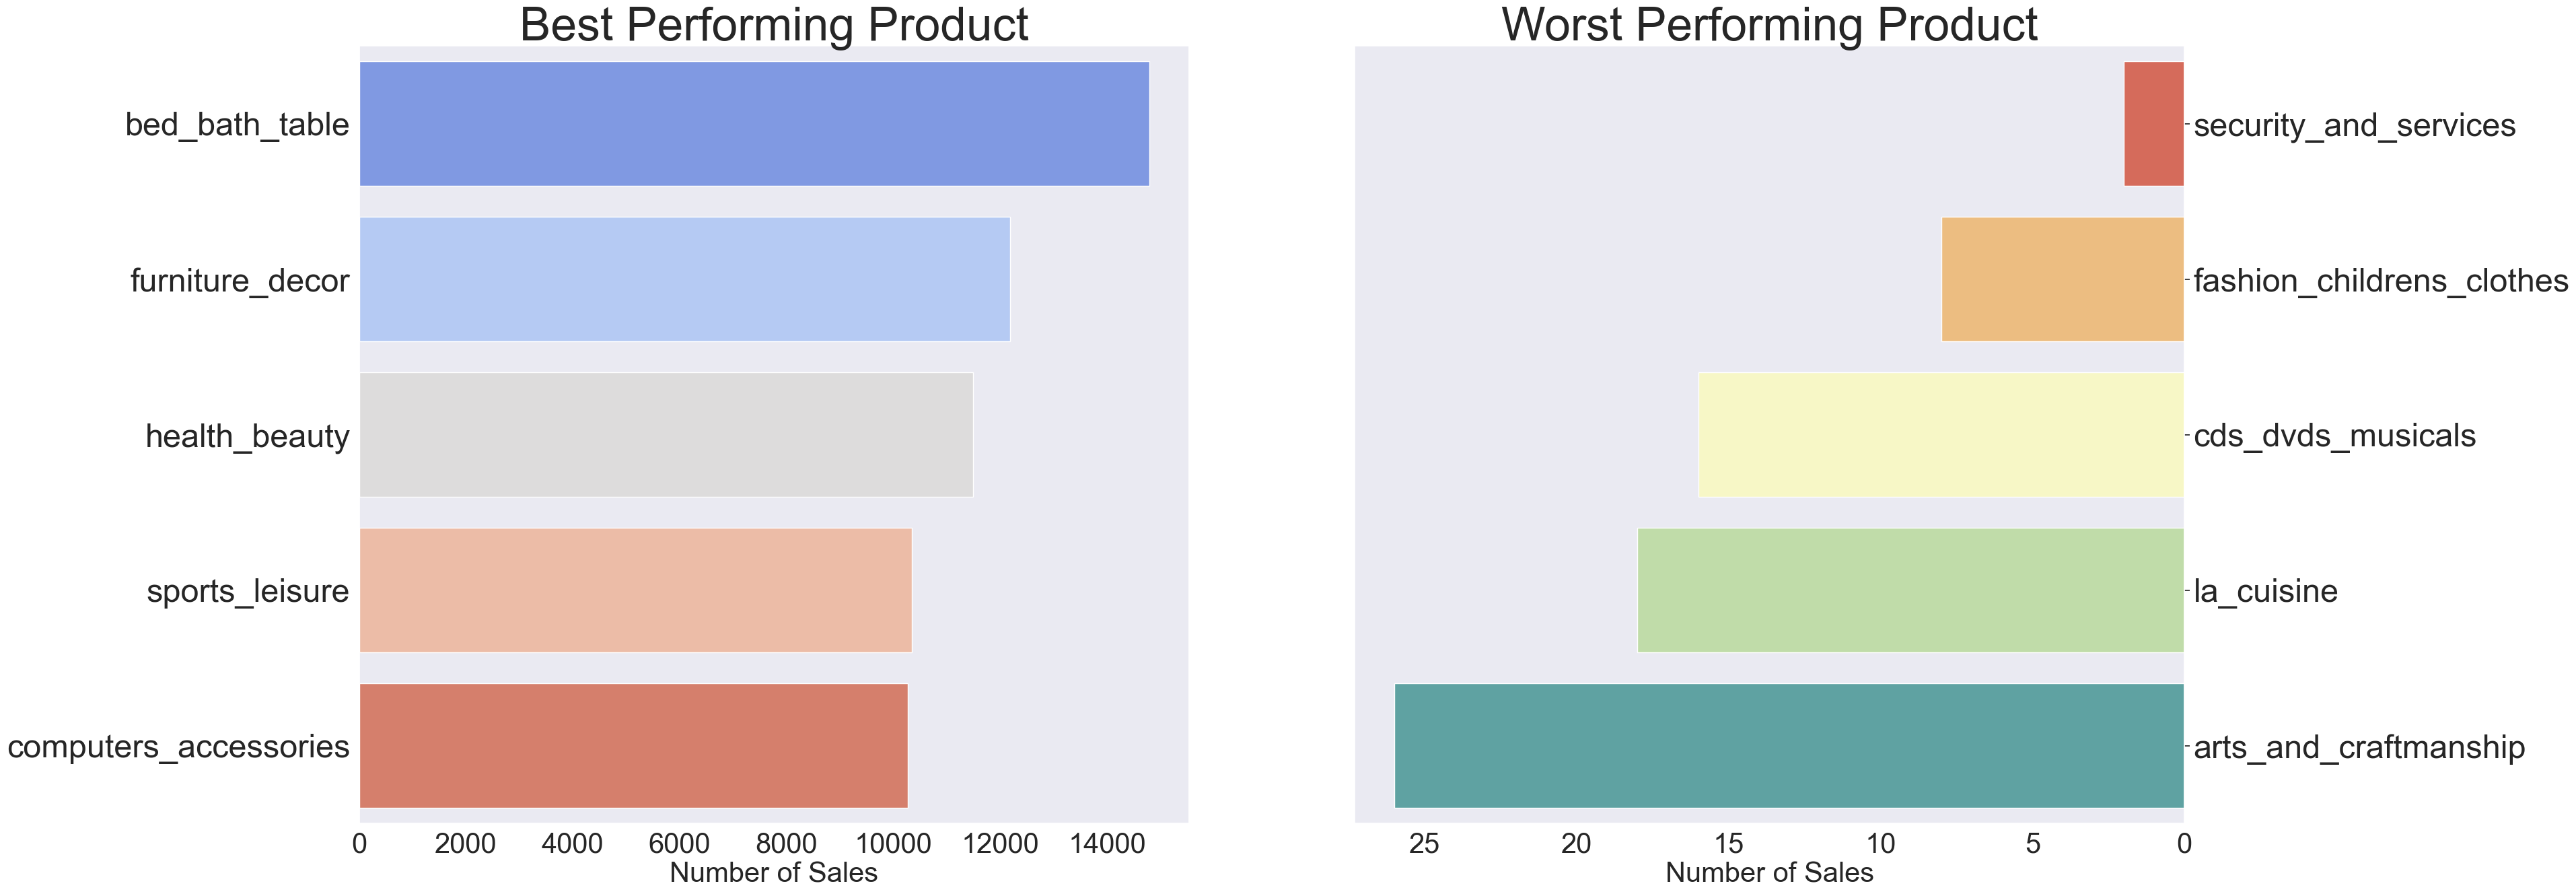

In [36]:
st.subheader("Best & Worst Performing Product")
 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(35, 15))
 
colors = ["#90CAF9", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
 
sns.barplot(x="order_item_id", y="product_category_name_english", data=sum_order_items_df.head(5), palette='coolwarm', ax=ax[0])
ax[0].set_ylabel(None)
ax[0].set_xlabel("Number of Sales", fontsize=30)
ax[0].set_title("Best Performing Product", loc="center", fontsize=50)
ax[0].tick_params(axis='y', labelsize=35)
ax[0].tick_params(axis='x', labelsize=30)
 
sns.barplot(x="order_item_id", y="product_category_name_english", data=sum_order_items_df.sort_values(by="order_item_id", ascending=True).head(5), palette='Spectral', ax=ax[1])
ax[1].set_ylabel(None)
ax[1].set_xlabel("Number of Sales", fontsize=30)
ax[1].invert_xaxis()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_title("Worst Performing Product", loc="center", fontsize=50)
ax[1].tick_params(axis='y', labelsize=35)
ax[1].tick_params(axis='x', labelsize=30)

In [17]:
main_df.head()

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,...,geolocation_lng_x,geolocation_city_x,geolocation_state_x,seller_zip_code,seller_city,seller_state,geolocation_lat_y,geolocation_lng_y,geolocation_city_y,geolocation_state_y
0,21490,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20 00:00:00,2.0,...,-60.695264,boa vista,RR,37580.0,monte siao,MG,-22.428805,-46.569550,monte siao,MG
1,21489,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20 00:00:00,1.0,...,-60.695264,boa vista,RR,37580.0,monte siao,MG,-22.428805,-46.569550,monte siao,MG
2,107239,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05 00:15:34,2016-10-07 13:17:15,NaN,NaT,2016-10-28 00:00:00,1.0,...,-52.407671,passo fundo,RS,81050.0,curitiba,PR,-25.495038,-49.299601,curitiba,PR
3,59932,809a282bbd5dbcabb6f2f724fca862ec,622e13439d6b5a0b486c435618b2679e,canceled,2016-09-13 15:24:19,2016-10-07 13:16:46,NaN,NaT,2016-09-30 00:00:00,NaN,...,-45.950860,sao jose dos campos,SP,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,89295,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,3.0,...,-47.858931,sao joaquim da barra,SP,81810.0,curitiba,PR,-25.507144,-49.272075,curitiba,PR


In [18]:
bypayment_df

,payment_type,customer_count
0,boleto,19784
1,credit_card,76505
2,debit_card,1528
3,not_defined,3
4,voucher,3865


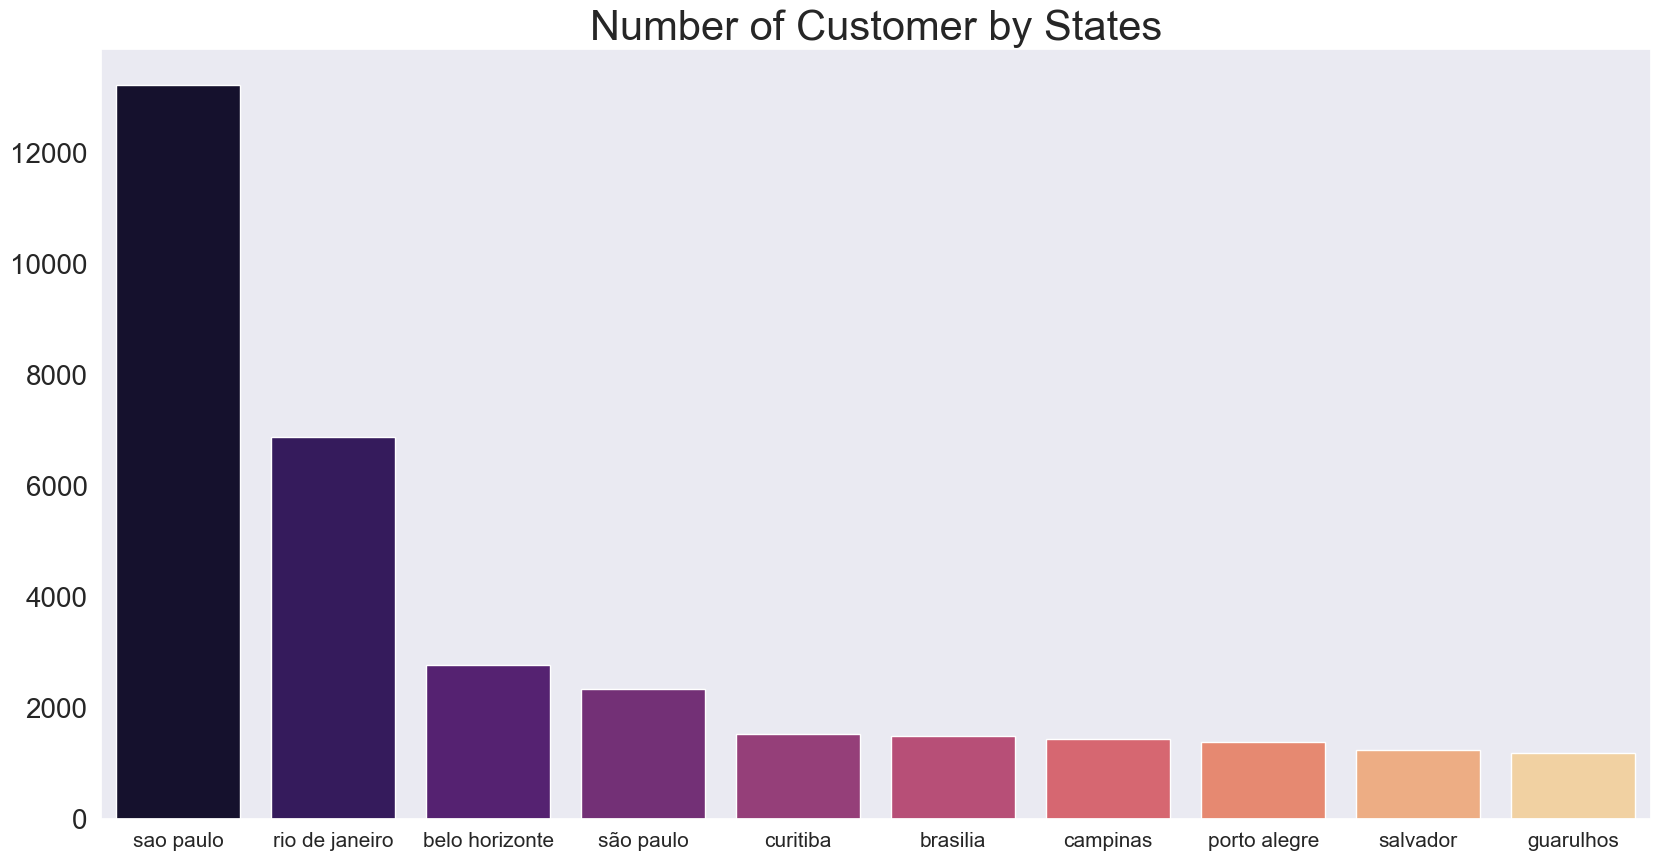

In [24]:
st.subheader("Customer Demographics")
fig, ax = plt.subplots(figsize=(20, 10))
colors = ["#90CAF9", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]

sns.barplot(
    y="customer_count", 
    x="geolocation_city_x",
    data=bycity_df.sort_values(by="customer_count", ascending=False),
    palette='magma',
    ax=ax
)
ax.set_title("Number of Customer by States", loc="center", fontsize=30)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=15)

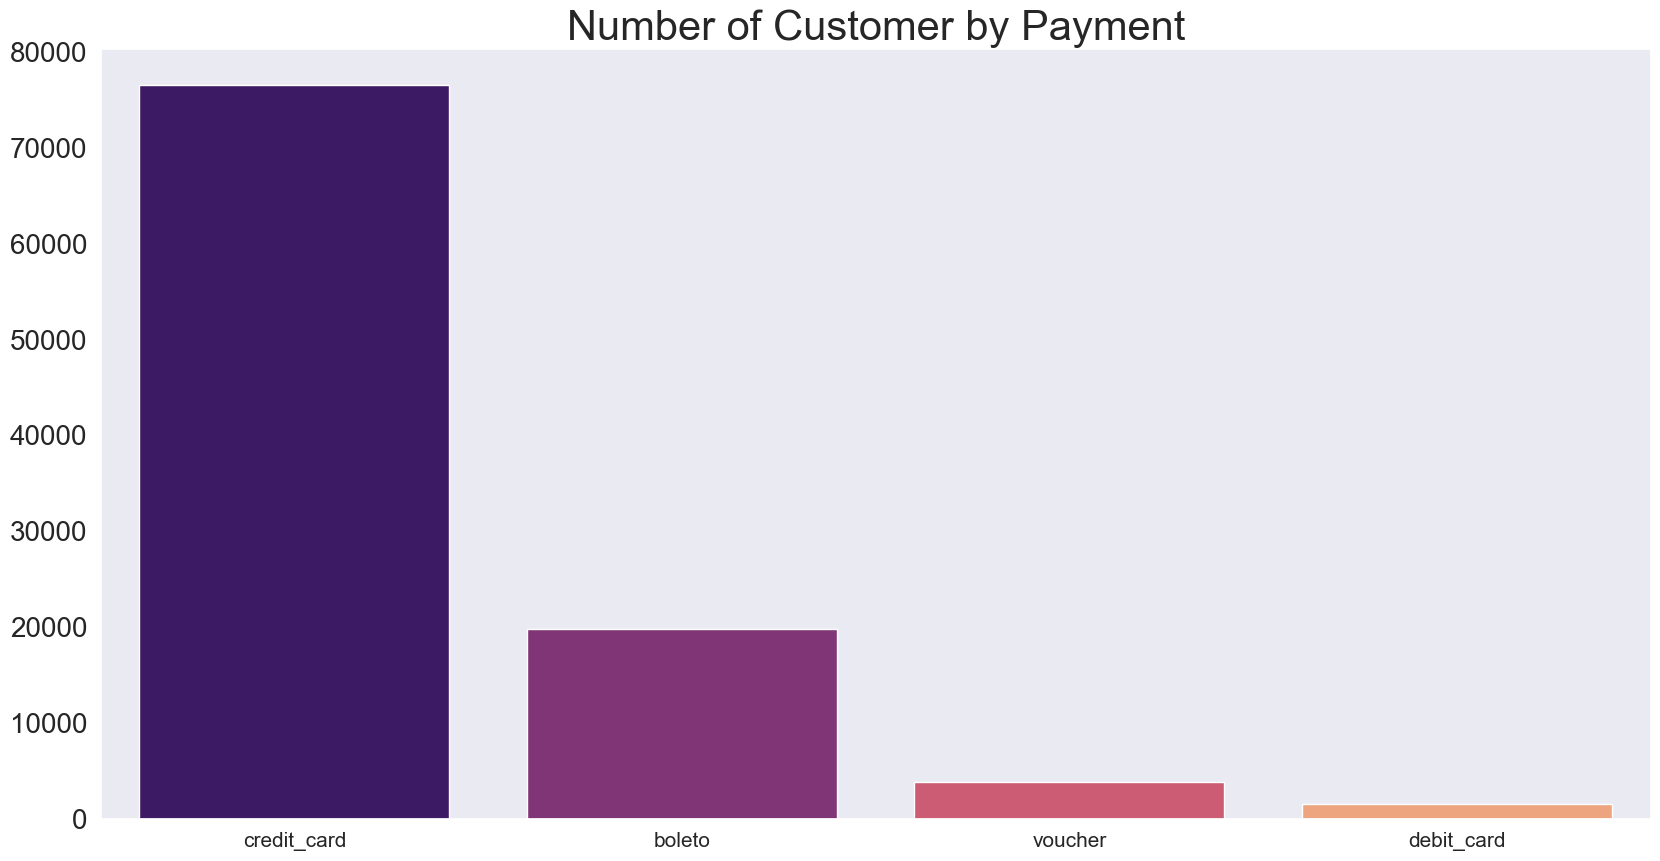

In [26]:
st.subheader("Customer Payment Method")
fig, ax = plt.subplots(figsize=(20, 10))
colors = ["#90CAF9", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]

sns.barplot(
    y="customer_count", 
    x="payment_type",
    data=bypayment_df.sort_values(by="customer_count", ascending=False)[0:4],
    palette='magma',
    ax=ax
)
ax.set_title("Number of Customer by Payment", loc="center", fontsize=30)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=15)

Sehingga didapatkan kesimpulan dalam menjawab pertanyaan bisnis tersebut yaitu:

-bed_bath_table adalah produk yang paling banyak dibeli

-Sao Paulo merupakan wilayah yang paling banyak membeli produk perusahaan

-credit card adalah metode pembayaran yang paling banyak digunakan oleh customer